In [2]:
"""
This script builds and trains a Convolutional Neural Network (CNN)
to classify images from local MNIST CSV files. It uses a dedicated
training file and a separate testing file.
After training, it uses the model to predict a handwritten digit from a
local image file named 'number.png'.

Download available, required CSV files from Kaggle:
https://www.kaggle.com/datasets/oddrationale/mnist-in-csv
"""

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 # Import OpenCV for image processing


In [3]:

# Define the names of your local CSV files
TRAIN_CSV_FILE_PATH = 'mnist_train.csv'
TEST_CSV_FILE_PATH = 'mnist_test.csv'

# 1. Load the MNIST dataset from separate train and test files
try:
    train_df = pd.read_csv(TRAIN_CSV_FILE_PATH)
    test_df = pd.read_csv(TEST_CSV_FILE_PATH)
except FileNotFoundError as e:
    print(f"Error: A required file was not found ({e.filename}).")
    print("Please make sure both 'mnist_train.csv' and 'mnist_test.csv' are in the same directory as this script.")
    exit() # Exit the script if files are not found


In [26]:

# 2. Process the training data
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values
# Normalize and reshape the training images
train_images = train_images.astype('float32') / 255.0
train_images = train_images.reshape(-1, 28, 28, 1)

# 3. Process the testing data
test_labels = test_df['label'].values
test_images = test_df.drop('label', axis=1).values
# Normalize and reshape the testing images
test_images = test_images.astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1)

#4 Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

#5 compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#6 train the model
print("Starting Model Training...")
history = model.fit(train_images, train_labels, epochs=3,
                    validation_data=(test_images, test_labels))
print("Model Training Complete...")


--- Starting Model Training ---
Epoch 1/3


/Users/leonardofloresgonzalez/CNN MNSIT Project/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9625 - loss: 0.1221 - val_accuracy: 0.9872 - val_loss: 0.0418
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9874 - loss: 0.0402 - val_accuracy: 0.9875 - val_loss: 0.0380
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9917 - loss: 0.0271 - val_accuracy: 0.9881 - val_loss: 0.0350
--- Model Training Complete ---


In [27]:

# 7. display model accuracy
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc:.3}')


313/313 - 1s - 2ms/step - accuracy: 0.9881 - loss: 0.0350

Test accuracy: 0.988


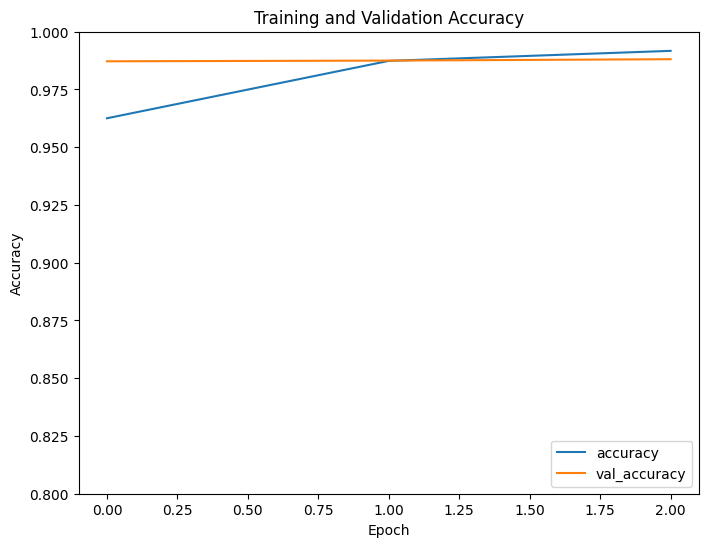

In [28]:

# 8. plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()



--- Predicting Digit from Local Image ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The predicted digit is: 4
Confidence: 100.00%


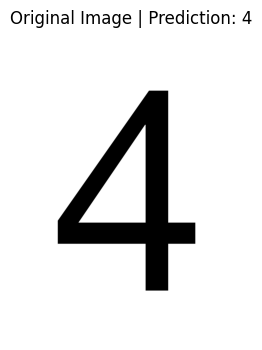

In [32]:

# 9. test model with local png
print("\n--- Predicting Digit from Local Image ---")
IMAGE_FILE_TO_TEST = 'number4.png'

try:
    # Read the image in grayscale
    img = cv2.imread(IMAGE_FILE_TO_TEST, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError

    # invert the image, model was trained on black background, white digit
    img_inverted = cv2.bitwise_not(img)
    
    # use simple threshold to make the image binary
    _, binary = cv2.threshold(img_inverted, 128, 255, cv2.THRESH_BINARY)

    # find contours to locate the digit
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("Could not find any digit in the image. Make sure the digit is clear.")
    else:
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get the bounding box of the digit
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        digit = binary[y:y+h, x:x+w]

        # add padding to make it square and resize to 28x28
        side = max(w, h)
        padded_digit = np.zeros((side, side), dtype=np.uint8)
        x_offset = (side - w) // 2
        y_offset = (side - h) // 2
        padded_digit[y_offset:y_offset+h, x_offset:x_offset+w] = digit
        
        # add some border padding before resizing to better match MNIST format
        padded_digit = cv2.copyMakeBorder(padded_digit, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=0)

        # resize to 28x28 for the model
        resized_digit = cv2.resize(padded_digit, (28, 28))
        
        # prep the image for the model
        processed_digit = resized_digit.astype('float32') / 255.0
        model_input = processed_digit.reshape(1, 28, 28, 1)
        
        # make prediction
        prediction = model.predict(model_input)
        predicted_digit = np.argmax(prediction)
        confidence = np.max(prediction) * 100

        print(f"The predicted digit is: {predicted_digit}")
        print(f"Confidence: {confidence:.2f}%")

        # display the original image with the prediction
        plt.figure(figsize=(4, 4))
        plt.imshow(img, cmap='gray')
        plt.title(f"Original Image | Prediction: {predicted_digit}")
        plt.axis('off')
        plt.show()

except FileNotFoundError:
    print(f"\nError: '{IMAGE_FILE_TO_TEST}' not found.")
    print(" create an image of a handwritten digit and upload it.")
except Exception as e:
    print(f"An error occurred during image processing: {e}")

